## Get the data

In [1]:
!pip install awscli
!aws s3 ls --no-sign-request s3://multiconer/multiconer2023/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 kB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
                           PRE BN-Bangla/
                           PRE DE-German/
                           PRE EN-English/
                           PRE ES-Spanish/
                           PRE FA-Farsi/
                           PRE FR-French/
                           PRE HI-Hindi/
     

Download only English data

In [2]:
!aws s3 cp s3://multiconer/multiconer2023/EN-English  ./multiconer2023 --recursive --no-sign-request

download: s3://multiconer/multiconer2023/EN-English/en_dev.conll to multiconer2023/en_dev.conll
download: s3://multiconer/multiconer2023/EN-English/en_train.conll to multiconer2023/en_train.conll
download: s3://multiconer/multiconer2023/EN-English/en_test.conll to multiconer2023/en_test.conll


## Imports & Installs

In [3]:
!pip install stanza
!pip install sklearn-crfsuite
!pip install keras_preprocessing


import numpy as np
import pandas as pd
from argparse import ArgumentParser
import json
import glob
import os
from os.path import join
import stanza
import nltk
nltk.download('averaged_perceptron_tagger')
from itertools import chain
import sklearn
import scipy.stats
import sklearn_crfsuite
from sklearn_crfsuite import scorers,CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import metrics
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, TimeDistributed, Conv1D
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from google.colab import files
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix
from keras.callbacks import EarlyStopping

sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.5/802.5 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 30.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=2023e359c217d5248a45657f38b389f75e024769118d8121799545224098da33
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.6 MB/s eta 0:00:00


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Data Reader

In [4]:
def process(in_path, o_path, mode):
    dataset = []
    domain_ds = read_conllu(in_path, mode)
    sents = [obj['tokens'] for obj in domain_ds]
    dataset.extend(domain_ds)
    df = pd.DataFrame(domain_ds)
    if not os.path.exists(o_path):
        os.makedirs(o_path)
    df.to_csv(o_path+f'/{mode}.csv',index=False)

def read_conllu(filename, mode):
    dataset = []
    with open(filename, encoding='utf-8') as f:
        sentence = []
        ner_tags = []
        obj = {}
        for row in f:
            row = row.strip()

            # This sentence is complete, add to list and initialize next one
            if len(row) == 0 and len(sentence) > 0:
                obj['tokens'] = sentence
                if mode!="test_data":
                    obj['ner_tags'] = ner_tags
                dataset.append(obj)
                sentence = []
                ner_tags = []
                obj = {}
            
            elif len(row) == 0:
              continue

            # If it is a comment, add the data to the object
            elif row[0] == '#' and len(row.split()) == 4:
                obj['id'] = row.split()[2]
                obj['domain'] = row.split()[3].split('=')[1]

            # If it is not a comment, add words to sentence
            else:
                sentence.append(row.split()[0])
                if mode!="test_data":
                    ner_tags.append(row.split()[3])
                
    return dataset

## Process train, validation, and test data into dataframes

In [5]:
process("/content/multiconer2023/en_dev.conll","/content/multiconer2023/data","val_data")
process("/content/multiconer2023/en_train.conll","/content/multiconer2023/data","train_data")
process("/content/multiconer2023/en_test.conll","/content/multiconer2023/data","test_data")

# Task 2 - BiLSTM for NER

In [6]:
trainData = pd.read_csv('/content/multiconer2023/data/train_data.csv')
testData = pd.read_csv('/content/multiconer2023/data/test_data.csv')
devData = pd.read_csv('/content/multiconer2023/data/val_data.csv')

## preprocess data

In [7]:
# PREPROCESSING
def preprocessing(data, dataType):
    data = data.drop_duplicates(subset=['id'])
    data = data.reset_index()
    data = data.drop(columns=['index'])
    data = data.drop(columns=['domain'])
    data['tokens'] = data['tokens'].apply(ast.literal_eval)

    if dataType != 'test':
        data['ner_tags'] = data['ner_tags'].apply(ast.literal_eval)
    return data

trainData = preprocessing(trainData, 'train')
testData = preprocessing(testData, 'test')
devData = preprocessing(devData, 'dev')

In [8]:
TD = pd.concat([trainData,devData],axis = 0)

In [10]:
# assign unique ids to each word/token
def preprocess(data,mode):
    word2id = {}
    id2word = {}
    tag2id = {}
    id2tag = {}
    all_sent = data['tokens'].tolist()
    vocab = set()
    for sentence in all_sent:
        for word in sentence:
            vocab.add(word.lower())
    # give unique ids to words/tokens
    word2id = {word:id for id, word in enumerate(vocab)}
    id2word = {id:word for id, word in enumerate(vocab)}

    if mode != 'test':
        all_nertags = data['ner_tags'].tolist()
        nertags = set()
        for nertag in all_nertags:
            for tag in nertag:
                nertags.add(tag)
        tag2id = {tag:id for  id, tag in enumerate(nertags)}
        id2tag = {id:tag for  id, tag in enumerate(nertags)}
    return word2id, id2word, tag2id, id2tag

word2id, id2word, tag2id, id2tag = preprocess(TD,'train')
word2id_test, id2word_test, _, _ = preprocess(testData,'test')

In [13]:
train_sentences = [[word2id[word] for word in sentence] for sentence in trainData['tokens'].tolist()]
train_tags = [[tag2id[t] for t in tag] for tag in trainData['ner_tags'].tolist()]
dev_sentences = [[word2id[word] for word in sentence] for sentence in devData['tokens'].tolist()]
dev_tags = [[tag2id[t] for t in tag] for tag in devData['ner_tags'].tolist()]
test_sentences = [[word2id_test[word] for word in sentence] for sentence in testData['tokens'].tolist()]

In [14]:
max_length = max(len(sentence) for sentence in train_sentences + dev_sentences + test_sentences)
max_length

68

In [17]:
num_words = len(word2id)
num_words

35233

In [15]:
num_labels = len(tag2id)
num_labels

67

In [18]:
padding_value = tag2id['O']
padding_value

9

In [19]:
train_sentences = pad_sequences(train_sentences, maxlen=max_length, padding='post', value = padding_value)
train_tags = pad_sequences(train_tags, maxlen=max_length, padding='post',value = padding_value)
train_final = train_tags
train_tags = to_categorical(train_tags, num_classes=num_labels)
dev_sentences = pad_sequences(dev_sentences, maxlen=max_length, padding='post',value = padding_value)
dev_tags = pad_sequences(dev_tags, maxlen=max_length, padding='post',value = padding_value)
dev_final = dev_tags
dev_tags = to_categorical(dev_tags, num_classes=num_labels)
test_sentences = pad_sequences(test_sentences, maxlen=max_length, padding='post',value = padding_value)

In [20]:
trainData['tokens'][0]

['robert',
 'gottschalk',
 '1939',
 'academy',
 'award',
 'winner',
 'and',
 'founder',
 'of',
 'panavision']

In [21]:
train_sentences[0]

array([10659, 10889,  2797, 15536,  3736, 26498, 21010,  4452, 11149,
       11379,     9,     9,     9,     9,     9,     9,     9,     9,
           9,     9,     9,     9,     9,     9,     9,     9,     9,
           9,     9,     9,     9,     9,     9,     9,     9,     9,
           9,     9,     9,     9,     9,     9,     9,     9,     9,
           9,     9,     9,     9,     9,     9,     9,     9,     9,
           9,     9,     9,     9,     9,     9,     9,     9,     9,
           9,     9,     9,     9,     9], dtype=int32)

In [22]:
vocab_size = len(id2word)
input_length = max_length
output_dim = 50

### BiLSTM

In [23]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=output_dim, input_length=input_length))
model.add(Bidirectional(LSTM(units=25, return_sequences=True, dropout=0.2), merge_mode = 'concat'))
model.add(TimeDistributed(Dense(num_labels, activation='softmax')))
adam = Adam(learning_rate = 0.0001)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hist = model.fit(train_sentences, train_tags, validation_data=(dev_sentences, dev_tags), epochs=10, batch_size=512, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 68, 50)            1761650   
                                                                 
 bidirectional (Bidirectiona  (None, 68, 50)           15200     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 68, 67)           3417      
 ibuted)                                                         
                                                                 
Total params: 1,780,267
Trainable params: 1,780,267
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
33/33 [==============================] - 22s 410ms/step - loss: 3.0211 - accuracy: 0.9001 - val_loss: 0.9911 - val_accuracy: 0.9535
Epoch 2/10
33/33 [=================

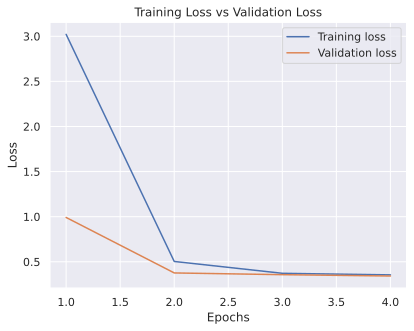

In [24]:
epochs = range(1, len(hist.history['loss']) + 1)
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

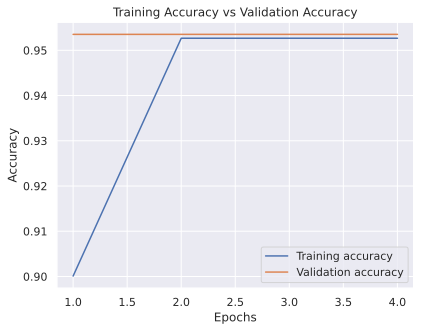

In [25]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

plt.plot(epochs, acc, label='Training accuracy')    
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
#Results
dev = np.array(dev_final).flatten()
y_pred = model.predict(dev_sentences)
predicted_labels = np.argmax(y_pred,axis = -1)
pl = np.array(predicted_labels).flatten()
print(classification_report(dev,pl,target_names = id2tag.values(),digits=4))

28/28 [==============================] - 0s 4ms/step
                         precision    recall  f1-score   support

              B-Disease     0.0000    0.0000    0.0000        18
          I-MusicalWork     0.0000    0.0000    0.0000       108
  I-AnatomicalStructure     0.0000    0.0000    0.0000         4
              I-Station     0.0000    0.0000    0.0000        27
                B-Drink     0.0000    0.0000    0.0000        11
     I-MedicalProcedure     0.0000    0.0000    0.0000         9
            B-OtherPROD     0.0000    0.0000    0.0000        49
             I-OtherPER     0.0000    0.0000    0.0000       122
             B-OtherLOC     0.0000    0.0000    0.0000        16
                      O     0.9535    1.0000    0.9762     56475
          B-MusicalWork     0.0000    0.0000    0.0000        61
              B-Symptom     0.0000    0.0000    0.0000        10
               I-Cleric     0.0000    0.0000    0.0000        16
     B-MedicalProcedure     0.0000  

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## BiLSTM with word embedding

### glove 

In [29]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-04-23 15:46:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-23 15:46:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-23 15:46:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [30]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
  return word_to_vec_map


word_to_vec_map = read_glove_vector('/content/glove.6B.50d.txt')

vocab_len = len(word2id)
embed_vector_len = word_to_vec_map['eli'].shape[0]
print('Length of vector:',embed_vector_len)

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in word2id.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=max_length, weights = [emb_matrix], trainable=False)

Length of vector: 50


In [31]:
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(units=25, return_sequences=True, dropout=0.2), merge_mode = 'concat'))
model.add(TimeDistributed(Dense(num_labels, activation='softmax')))
adam = Adam(learning_rate = 0.0001)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hist = model.fit(train_sentences, train_tags, validation_data=(dev_sentences, dev_tags), epochs=10, batch_size=512, callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 68, 50)            1761650   
                                                                 
 bidirectional_1 (Bidirectio  (None, 68, 50)           15200     
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 68, 67)           3417      
 tributed)                                                       
                                                                 
Total params: 1,780,267
Trainable params: 18,617
Non-trainable params: 1,761,650
_________________________________________________________________
Epoch 1/10
33/33 [==============================] - 6s 60ms/step - loss: 2.6256 - accuracy: 0.7022 - val_loss: 0.9948 - val_accuracy: 0.9535
Epoch 2/10
33/33 [============

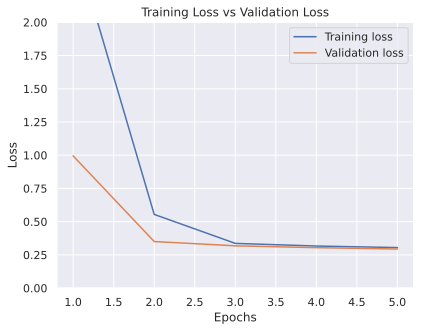

In [32]:
epochs = range(1, len(hist.history['loss']) + 1)
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend()
plt.show()

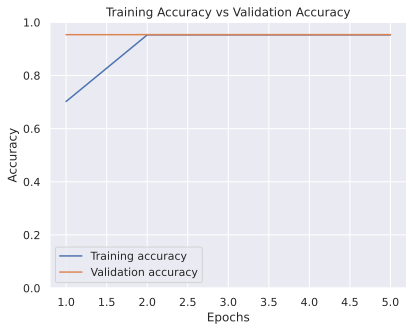

In [33]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

plt.plot(epochs, acc, label='Training accuracy')    
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [34]:
#Results
dev = np.array(dev_final).flatten()
y_pred = model.predict(dev_sentences)
predicted_labels = np.argmax(y_pred,axis = -1)
pl = np.array(predicted_labels).flatten()
print(classification_report(dev, pl, target_names = id2tag.values(), digits=4))

28/28 [==============================] - 1s 4ms/step
                         precision    recall  f1-score   support

              B-Disease     0.0000    0.0000    0.0000        18
          I-MusicalWork     0.0000    0.0000    0.0000       108
  I-AnatomicalStructure     0.0000    0.0000    0.0000         4
              I-Station     0.0000    0.0000    0.0000        27
                B-Drink     0.0000    0.0000    0.0000        11
     I-MedicalProcedure     0.0000    0.0000    0.0000         9
            B-OtherPROD     0.0000    0.0000    0.0000        49
             I-OtherPER     0.0000    0.0000    0.0000       122
             B-OtherLOC     0.0000    0.0000    0.0000        16
                      O     0.9535    1.0000    0.9762     56475
          B-MusicalWork     0.0000    0.0000    0.0000        61
              B-Symptom     0.0000    0.0000    0.0000        10
               I-Cleric     0.0000    0.0000    0.0000        16
     B-MedicalProcedure     0.0000  

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Predictions file

In [35]:
dev_ori = [[word2id_test[word] for word in sentence] for sentence in testData['tokens'].tolist()]
tokens_list = [[sentence]for sentence in testData['tokens'].tolist()]
predicted_list = []

In [36]:
for i in range(1000):
  sent = test_sentences[i]
  l = dev_ori[i]
  padded_sentence = pad_sequences([sent], maxlen=max_length, padding='post')
  y_pred = model.predict(padded_sentence,verbose = 0)
  y_pred = np.argmax(y_pred, axis = -1)
  predicted_tags = [id2tag[pred] for pred in y_pred[0]]
  predicted_list.append(predicted_tags[:len(l)])

In [37]:
percentile_list = pd.DataFrame(list(zip(tokens_list,predicted_list)),columns=['tokens','predictions'])
percentile_list.to_csv("predictions_bilstm.csv")